# Disaster Tweets Kaggle Competition

The goal of this project is to predict which tweets are about a disaster using natural language processing.

## Import Statements

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re

from tqdm import tqdm
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

stop = set(stopwords.words('english'))

from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras
from keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

## Exploratory Data Analysis

Let us look at what the dataset looks like first.

In [4]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
df_train.tail()

,id,keyword,location,text,target
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1
7612,10873,NaN,NaN,The Latest: More Homes Razed by Northern Calif...,1


We see missing values for keyword and location. Let's see how many there are for every column.

In [6]:
df_train.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

This is interesting. Fortunately, we won't be using keyword and location for the predictions. The tweet itself should be more than enough.

Let us also look at how many of the tweet are actually about disasters and how many aren't.

<Axes: xlabel='target', ylabel='count'>

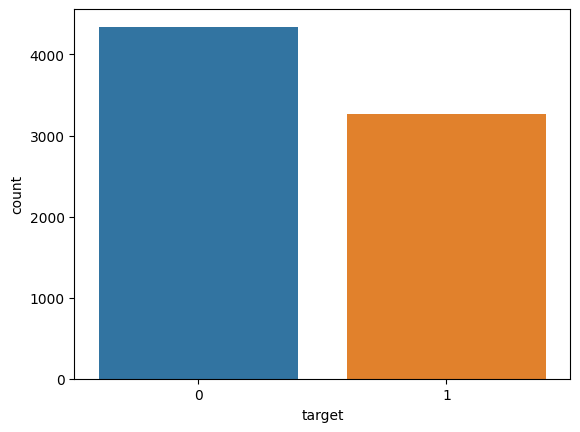

In [26]:
target_counts = df_train['target'].value_counts()
sns.barplot(x=target_counts.index,y=target_counts)

Now it's time to perform some cleaning by removing data from the text that we don't need.

In [10]:
# Removing <> tags

def clean_text(text):
    # Removing <> tags
    text = re.sub('<.*?>+', '', text)
    text = text.lower()
    # Removing puntuctions
    table = str.maketrans('','',string.punctuation)
    text = text.translate(table)
    # Removing URL
    text = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+",'',text)
    # Removing Emojis
    emojis = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    
    text = re.sub(emojis,'',text)
    return text


In [11]:
df_train['cleaned_text'] = df_train['text'].apply(lambda x : clean_text(x))

df_test['cleaned_text'] = df_test['text'].apply(lambda x : clean_text(x))

It might also be useful to look at the distribution of the word count for the tweets.

<Axes: ylabel='Density'>

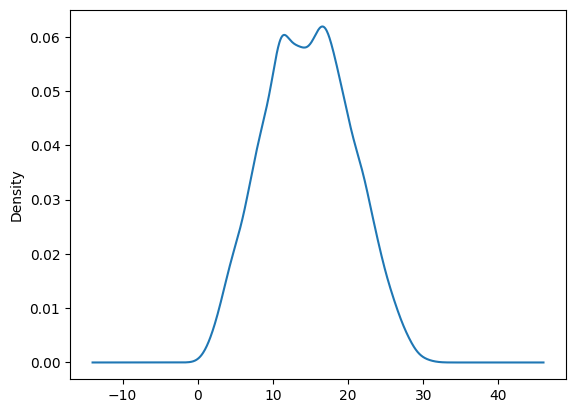

In [16]:
df_train['totalwords'] = df_train['cleaned_text'].str.split().str.len()
df_train['totalwords'].plot.kde()

## Processing Data

It's time to convert the text into a format that we can use as imput for the neural network. The below code adds every word from the tweet into a list that will later be used to convert the words into numbers. I've done this for both the train and test data.

In [10]:
train_words = []
for review in tqdm(df_train['cleaned_text']):
    words = [ word.lower() for word in word_tokenize(review) if (word.isalpha() == 1 ) & (word not in stop) ]
    train_words.append(words)

test_words = []
for review in tqdm(df_test['cleaned_text']):
    words = [ word.lower() for word in word_tokenize(review) if (word.isalpha() == 1 ) & (word not in stop) ]
    test_words.append(words)

all_words = train_words + test_words

100%|█████████████████████████████████████████████████████████████████████████████████████████| 3263/3263 [00:00<00:00, 20876.10it/s]


Now it's time to actually tokenize the words. I'm using NLTK, which actually returns the **syllables** from the words. I'm fitting the tokenizer on both train and test data the words but converting the sequences only for the training data.

In [11]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_words)
train_sequences = tokenizer.texts_to_sequences(train_words)

train_pad = pad_sequences(train_sequences, maxlen=100)

In [12]:
word2index = tokenizer.word_index
print("Number of unique tokens : ",len(word2index)+1)

Number of unique tokens :  21324


In [13]:
X_train,X_val,y_train,y_val = train_test_split(train_pad, df_train['target'].values, test_size = 0.2, random_state = 0)

## Models
I'll be trying this with multiple RNN models that are provided by Keras. The first layer is always the embeddings layer, but the hidden layers use RNN.

### Simple RNN
This uses a vanilla RNN layer without any modifications. Let us see how it performs.

In [15]:
model1 = keras.Sequential()
# Add an Embedding layer expecting input vocab of size 1000, and
# output embedding dimension of size 64.
model1.add(layers.Embedding(input_dim=len(word2index)+1,input_length=100, output_dim=128))

# Add a LSTM layer with 128 internal units.
model1.add(layers.SimpleRNN(128))

# Add a Dense layer with 10 units.
model1.add(layers.Dense(1, activation='sigmoid'))

model1.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 128)          2729472   
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 128)               32896     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 2762497 (10.54 MB)
Trainable params: 2762497 (10.54 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [16]:
model1.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [17]:
history1=model1.fit(X_train,y_train,batch_size=64,epochs=10,validation_data=(X_val,y_val))

Epoch 1/10


2023-07-29 18:56:31.092182: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-07-29 18:56:31.137122: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fb676981340 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-29 18:56:31.137151: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2023-07-29 18:56:31.141457: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-29 18:56:31.150857: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8902
2023-07-29 18:56:31.226640: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifeti

96/96 [==============================] - 10s 97ms/step - loss: 0.6505 - accuracy: 0.6136 - val_loss: 0.5480 - val_accuracy: 0.7538
Epoch 2/10
96/96 [==============================] - 6s 62ms/step - loss: 0.3154 - accuracy: 0.8796 - val_loss: 0.5213 - val_accuracy: 0.7505
Epoch 3/10
96/96 [==============================] - 4s 38ms/step - loss: 0.1118 - accuracy: 0.9663 - val_loss: 0.5987 - val_accuracy: 0.7400
Epoch 4/10
96/96 [==============================] - 4s 37ms/step - loss: 0.0659 - accuracy: 0.9783 - val_loss: 0.5896 - val_accuracy: 0.7702
Epoch 5/10
96/96 [==============================] - 3s 36ms/step - loss: 0.0534 - accuracy: 0.9821 - val_loss: 0.6252 - val_accuracy: 0.7459
Epoch 6/10
96/96 [==============================] - 3s 36ms/step - loss: 0.0526 - accuracy: 0.9811 - val_loss: 0.6521 - val_accuracy: 0.7525
Epoch 7/10
96/96 [==============================] - 3s 30ms/step - loss: 0.0483 - accuracy: 0.9826 - val_loss: 0.6296 - val_accuracy: 0.7689
Epoch 8/10
96/96 [=====

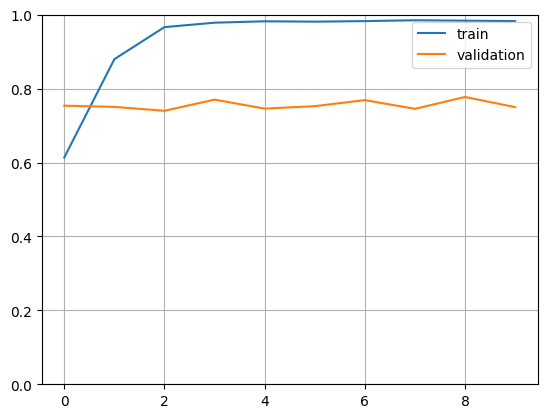

In [18]:
plt.figure()
plt.ylim([0, 1])
plt.plot(history1.history['accuracy'], label='train')
plt.plot(history1.history['val_accuracy'], label='validation')
plt.legend()
plt.grid()
plt.show()

It looks like the model performance initially improved on the training data but was consistent across epoches throughout the validation models. Let us use a different model and see if it performs better.

### LTSM Model

In [19]:
model2 = keras.Sequential()
# Add an Embedding layer expecting input vocab of size 1000, and
# output embedding dimension of size 64.
model2.add(layers.Embedding(input_dim=len(word2index)+1,input_length=100, output_dim=64))

# Add a LSTM layer with 128 internal units.
model2.add(layers.LSTM(128))

# Add a Dense layer with 10 units.
model2.add(layers.Dense(1, activation='sigmoid'))

model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 64)           1364736   
                                                                 
 lstm (LSTM)                 (None, 128)               98816     
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1463681 (5.58 MB)
Trainable params: 1463681 (5.58 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
model2.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [21]:
history2=model2.fit(X_train,y_train,batch_size=64,epochs=10,validation_data=(X_val,y_val))

Epoch 1/10
96/96 [==============================] - 10s 90ms/step - loss: 0.5844 - accuracy: 0.6903 - val_loss: 0.4490 - val_accuracy: 0.7879
Epoch 2/10
96/96 [==============================] - 3s 34ms/step - loss: 0.3080 - accuracy: 0.8773 - val_loss: 0.4699 - val_accuracy: 0.7951
Epoch 3/10
96/96 [==============================] - 2s 17ms/step - loss: 0.1700 - accuracy: 0.9392 - val_loss: 0.5713 - val_accuracy: 0.7945
Epoch 4/10
96/96 [==============================] - 2s 16ms/step - loss: 0.1058 - accuracy: 0.9635 - val_loss: 0.5938 - val_accuracy: 0.7800
Epoch 5/10
96/96 [==============================] - 1s 13ms/step - loss: 0.0867 - accuracy: 0.9722 - val_loss: 0.6941 - val_accuracy: 0.7761
Epoch 6/10
96/96 [==============================] - 2s 16ms/step - loss: 0.0697 - accuracy: 0.9742 - val_loss: 0.7255 - val_accuracy: 0.7892
Epoch 7/10
96/96 [==============================] - 1s 10ms/step - loss: 0.0559 - accuracy: 0.9783 - val_loss: 0.7406 - val_accuracy: 0.7722
Epoch 8/10
9

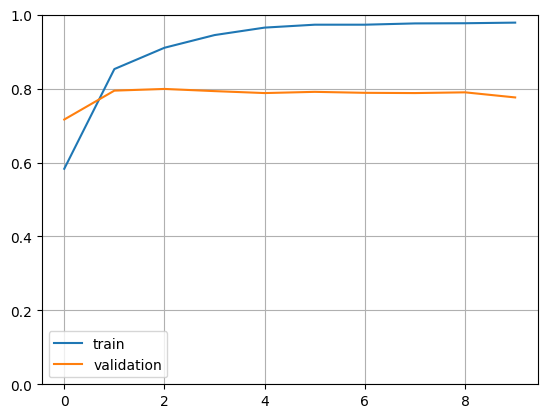

In [33]:
plt.figure()
plt.ylim([0, 1])
plt.plot(history2.history['accuracy'], label='train')
plt.plot(history2.history['val_accuracy'], label='validation')
plt.legend()
plt.grid()
plt.show()

Here, the validation accuracy seems to be consistent after the first epoch. This model also seems to perform better than the Simple RNN model.

### GRU RNN Model

In [22]:
model3 = keras.Sequential()
# Add an Embedding layer expecting input vocab of size 1000, and
# output embedding dimension of size 64.
model3.add(layers.Embedding(input_dim=len(word2index)+1,input_length=100, output_dim=64))

# Add a LSTM layer with 128 internal units.
model3.add(layers.GRU(128))

# Add a Dense layer with 10 units.
model3.add(layers.Dense(1, activation='sigmoid'))

model3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 64)           1364736   
                                                                 
 gru (GRU)                   (None, 128)               74496     
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1439361 (5.49 MB)
Trainable params: 1439361 (5.49 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [23]:
model3.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [24]:
history3=model3.fit(X_train,y_train,batch_size=64,epochs=10,validation_data=(X_val,y_val))

Epoch 1/10
96/96 [==============================] - 7s 62ms/step - loss: 0.5809 - accuracy: 0.6882 - val_loss: 0.4514 - val_accuracy: 0.7984
Epoch 2/10
96/96 [==============================] - 3s 32ms/step - loss: 0.2964 - accuracy: 0.8824 - val_loss: 0.4755 - val_accuracy: 0.7932
Epoch 3/10
96/96 [==============================] - 2s 23ms/step - loss: 0.1652 - accuracy: 0.9394 - val_loss: 0.5358 - val_accuracy: 0.7768
Epoch 4/10
96/96 [==============================] - 1s 9ms/step - loss: 0.0972 - accuracy: 0.9662 - val_loss: 0.6570 - val_accuracy: 0.7630
Epoch 5/10
96/96 [==============================] - 1s 12ms/step - loss: 0.0720 - accuracy: 0.9772 - val_loss: 0.6674 - val_accuracy: 0.7630
Epoch 6/10
96/96 [==============================] - 1s 10ms/step - loss: 0.0620 - accuracy: 0.9798 - val_loss: 0.7020 - val_accuracy: 0.7840
Epoch 7/10
96/96 [==============================] - 1s 9ms/step - loss: 0.0542 - accuracy: 0.9819 - val_loss: 0.7332 - val_accuracy: 0.7800
Epoch 8/10
96/9

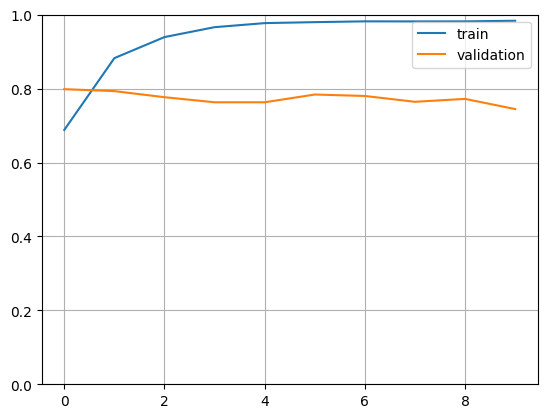

In [25]:
plt.figure()
plt.ylim([0, 1])
plt.plot(history3.history['accuracy'], label='train')
plt.plot(history3.history['val_accuracy'], label='validation')
plt.legend()
plt.grid()
plt.show()

This model doesn't perform as well as the LTSM model.

## Bidirectional RNN

Now let's try a different kind of RNN called a bidirectional RNN. It will have one LTSM layer since that's what performed best for the unidirectional models.

In [30]:
model4 = keras.Sequential()
# Add an Embedding layer expecting input vocab of size 1000, and
# output embedding dimension of size 64.
model4.add(layers.Embedding(input_dim=len(word2index)+1,input_length=100, output_dim=64))

# Add a LSTM layer with 128 internal units.
model4.add(layers.Bidirectional(layers.LSTM(128)))

# Add a Dense layer with 10 units.
model4.add(layers.Dense(1, activation='sigmoid'))

model4.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 100, 64)           1364736   
                                                                 
 bidirectional_1 (Bidirecti  (None, 256)               197632    
 onal)                                                           
                                                                 
 dense_5 (Dense)             (None, 1)                 257       
                                                                 
Total params: 1562625 (5.96 MB)
Trainable params: 1562625 (5.96 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [31]:
model4.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [32]:
history4=model4.fit(X_train,y_train,batch_size=64,epochs=10,validation_data=(X_val,y_val))

Epoch 1/10
96/96 [==============================] - 9s 68ms/step - loss: 0.5923 - accuracy: 0.6726 - val_loss: 0.4452 - val_accuracy: 0.7919
Epoch 2/10
96/96 [==============================] - 3s 35ms/step - loss: 0.3075 - accuracy: 0.8788 - val_loss: 0.4571 - val_accuracy: 0.7978
Epoch 3/10
96/96 [==============================] - 2s 21ms/step - loss: 0.1692 - accuracy: 0.9379 - val_loss: 0.5230 - val_accuracy: 0.7873
Epoch 4/10
96/96 [==============================] - 2s 18ms/step - loss: 0.1184 - accuracy: 0.9596 - val_loss: 0.6139 - val_accuracy: 0.7846
Epoch 5/10
96/96 [==============================] - 1s 15ms/step - loss: 0.0844 - accuracy: 0.9706 - val_loss: 0.6272 - val_accuracy: 0.7781
Epoch 6/10
96/96 [==============================] - 1s 12ms/step - loss: 0.0664 - accuracy: 0.9770 - val_loss: 0.7584 - val_accuracy: 0.7846
Epoch 7/10
96/96 [==============================] - 1s 13ms/step - loss: 0.0604 - accuracy: 0.9796 - val_loss: 0.7446 - val_accuracy: 0.7748
Epoch 8/10
96

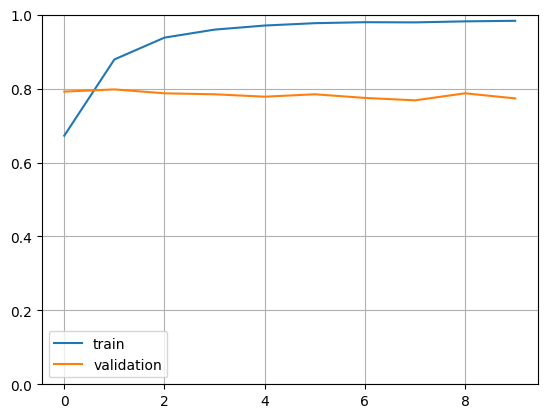

In [33]:
plt.figure()
plt.ylim([0, 1])
plt.plot(history4.history['accuracy'], label='train')
plt.plot(history4.history['val_accuracy'], label='validation')
plt.legend()
plt.grid()
plt.show()

This model performs well but not as good as the regular LTSM model.

### Extra hidden layer

Since the LTSM model performed the best, let's see if adding another hidden layer helps.

In [34]:
model5 = keras.Sequential()
# Add an Embedding layer expecting input vocab of size 1000, and
# output embedding dimension of size 64.
model5.add(layers.Embedding(input_dim=len(word2index)+1,input_length=100, output_dim=64))

# Add a LSTM layer with 128 internal units.
model5.add(layers.LSTM(128,return_sequences=True))

# Add a LSTM layer with 128 internal units.
model5.add(layers.LSTM(256))

# Add a Dense layer with 10 units.
model5.add(layers.Dense(1, activation='sigmoid'))

model5.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 100, 64)           1364736   
                                                                 
 lstm_3 (LSTM)               (None, 100, 128)          98816     
                                                                 
 lstm_4 (LSTM)               (None, 256)               394240    
                                                                 
 dense_6 (Dense)             (None, 1)                 257       
                                                                 
Total params: 1858049 (7.09 MB)
Trainable params: 1858049 (7.09 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [35]:
model5.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [36]:
history5=model5.fit(X_train,y_train,batch_size=64,epochs=10,validation_data=(X_val,y_val))

Epoch 1/10
96/96 [==============================] - 9s 68ms/step - loss: 0.6076 - accuracy: 0.6637 - val_loss: 0.4804 - val_accuracy: 0.7827
Epoch 2/10
96/96 [==============================] - 4s 38ms/step - loss: 0.3164 - accuracy: 0.8726 - val_loss: 0.4769 - val_accuracy: 0.7905
Epoch 3/10
96/96 [==============================] - 2s 20ms/step - loss: 0.1688 - accuracy: 0.9361 - val_loss: 0.5566 - val_accuracy: 0.7800
Epoch 4/10
96/96 [==============================] - 2s 19ms/step - loss: 0.1069 - accuracy: 0.9635 - val_loss: 0.6917 - val_accuracy: 0.7768
Epoch 5/10
96/96 [==============================] - 2s 20ms/step - loss: 0.0811 - accuracy: 0.9752 - val_loss: 0.6596 - val_accuracy: 0.7820
Epoch 6/10
96/96 [==============================] - 2s 18ms/step - loss: 0.0714 - accuracy: 0.9757 - val_loss: 0.7629 - val_accuracy: 0.7774
Epoch 7/10
96/96 [==============================] - 2s 17ms/step - loss: 0.0603 - accuracy: 0.9810 - val_loss: 0.7322 - val_accuracy: 0.7649
Epoch 8/10
96

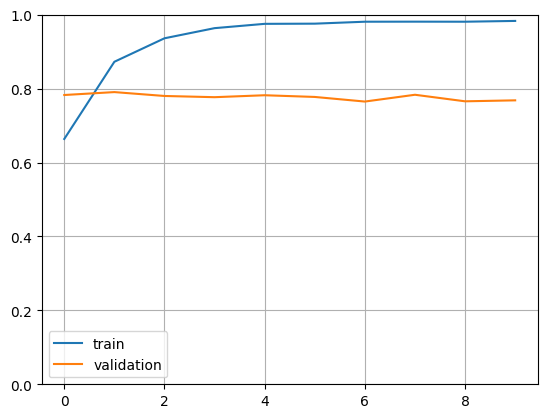

In [37]:
plt.figure()
plt.ylim([0, 1])
plt.plot(history5.history['accuracy'], label='train')
plt.plot(history5.history['val_accuracy'], label='validation')
plt.legend()
plt.grid()
plt.show()

The model performance is a little worse with a hidden layer. So I think it's best to stick to the original LTSM model.

## Test Data

Now it's time to generate the predictions for the test data.

In [38]:
test_sequences = tokenizer.texts_to_sequences(test_words)

test_pad = pad_sequences(test_sequences, maxlen=100)

In [48]:
sample_submission = pd.read_csv('data/sample_submission.csv')
sample_submission.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [49]:
predictions = model2.predict(test_pad)
predictions = np.round(predictions).astype(int)
submission = pd.DataFrame({'id' : df_test['id']})
submission['target'] = predictions
submission.head()

submission.to_csv('data/final_submission.csv', index=False)

102/102 [==============================] - 0s 2ms/step


## Conclusion

After trying multiple RNN models, it appears the LTSM model performed the best for the training data and the validation data after the split. Adding a hidden layer didn't appear to help. It might help to use transfer learning in this case. I plan to try it in the future and see if I notice any improvements.